In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/mpii_dataset.csv")
print(len(data))

2281


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2281 entries, 0 to 2280
Data columns (total 46 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   head_x          2281 non-null   float64
 1   head_y          2281 non-null   float64
 2   head_vis        2281 non-null   int64  
 3   upper_neck_x    2281 non-null   float64
 4   upper_neck_y    2281 non-null   float64
 5   upper_neck_vis  2281 non-null   int64  
 6   thorax_x        2281 non-null   int64  
 7   thorax_y        2281 non-null   int64  
 8   thorax_vis      2281 non-null   int64  
 9   lsho_x          2281 non-null   int64  
 10  lsho_y          2281 non-null   int64  
 11  lsho_vis        2281 non-null   int64  
 12  rsho_x          2281 non-null   int64  
 13  rsho_y          2281 non-null   int64  
 14  rsho_vis        2281 non-null   int64  
 15  lelb_x          2281 non-null   int64  
 16  lelb_y          2281 non-null   int64  
 17  lelb_vis        2281 non-null   i

In [5]:
# List columns with missing data
missing_data = data.isna().any()
columns_with_missing_data = missing_data[missing_data].index.tolist()
print(columns_with_missing_data)

[]


In [15]:
# Display the class imbalance
data["sport"].value_counts()

sport
1    1587
0     694
Name: count, dtype: int64

In [12]:
#Split the dataset into a stratified train and test set (80-20) using sport as the class labels
strat_train_set, strat_test_set = train_test_split(data, test_size=0.2, 
                                                   stratify=data['sport'], random_state = 42)


#Begin preparation of data for ML algorithms with fresh copy of training data
train_copy = strat_train_set.copy()
test_copy = strat_test_set.copy()

#Separate the predictors and the label (sport) in the train and test sets
train_data = train_copy.drop('sport', axis=1)
train_labels = train_copy['sport'].copy()
test_data = test_copy.drop('sport', axis=1)
test_labels = test_copy['sport'].copy()

# Final dataset shapes
print(f"Train rows: {train_data.shape[0]}, Test rows: {test_data.shape[0]}")

Train rows: 1824, Test rows: 457


In [13]:
# Verify that the class distributions are consistent throughout the three sets
print("Train class distribution:")
print(train_labels.value_counts(normalize=True))
print("\nValidation class distribution:")
print("\nTest class distribution:")
print(test_labels.value_counts(normalize=True))

Train class distribution:
sport
1    0.695724
0    0.304276
Name: proportion, dtype: float64

Validation class distribution:

Test class distribution:
sport
1    0.695842
0    0.304158
Name: proportion, dtype: float64


In [8]:
#Create pipelines for numerical attributes
#Imputer with median strategy and then a standard scaler is used on the numerical data
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

#Select columns with numerical attributes
preprocessing = make_column_transformer(
(num_pipeline, make_column_selector(dtype_include=np.number)),
)

In [16]:
# Create pipeline with preprocessing and a RandomForestClassifier with 10 cross validation folds. Also
# set class_weights to balanced to handle class imbalance
forest_classifier = make_pipeline(preprocessing, RandomForestClassifier(random_state=42, class_weight='balanced'))

# Define the hyperparameter grid to search
param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 150, 200, 300, 400], # Number of decision trees
    'randomforestclassifier__max_depth': [5, 10, 20, 30, None], 
    'randomforestclassifier__min_samples_split': list(range(2, 21)),  # Min samples to split a node
    'randomforestclassifier__min_samples_leaf': list(range(1, 11)),  # Min samples at a leaf node
}

# Set up the randomized search with cross-validation and f1_macro score because of class imbalance
random_search = RandomizedSearchCV(forest_classifier, 
                                   param_distributions=param_grid,
                                   scoring='f1_macro',
                                   n_iter=100, 
                                   cv=10, 
                                   random_state=42,
                                   n_jobs=-1,
                                   return_train_score=True,
                                   verbose=0)

# Fit on the training data
random_search.fit(train_data, train_labels)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x76fb659f1f60>)])),
                                             ('randomforestclassifier',
                                              RandomForestClassi...
                   param_distributions={'randomforestclassifier__max_depth': [5,
                                                                              10,
                                                                              20,
                                                                              30,
                                                                              None],
                                        'randomforestclassifier__min_samples_leaf': [1,
                                                                                     2,
                                                                                     3,
                                                                                     4,
                                                                                     5,
                                                                                     6,
                                                                                     7,
                                                                                     8,
                                                                                     9,
                                                                                     10],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      3,
                                                                                      4,
                                                                                      5,
                                                                                      6,
                                                                                      7,
                                                                                      8,
                                                                                      9,
                                                                                      10,
                                                                                      11,
                                                                                      12,
                                                                                      13,
                                                                                      14,
                                                                                      15,
                                                                                      16,
                                                                                      17,
                                                                                      18,
                                                                                      19,
                                                                                      20],
                                    

In [17]:
#Evaluate the model on the test set
final_predictions = random_search.best_estimator_.predict(test_data)

In [24]:
# Get the F1 macro score
print("F1-macro score:", f1_score(test_labels, final_predictions, average='macro'))

F1-macro score: 0.719181319720174


In [22]:
print(classification_report(test_labels, final_predictions, target_names=["Lawn Work", "Sport"]))

              precision    recall  f1-score   support

   Lawn Work       0.65      0.55      0.60       139
       Sport       0.82      0.87      0.84       318

    accuracy                           0.77       457
   macro avg       0.73      0.71      0.72       457
weighted avg       0.77      0.77      0.77       457



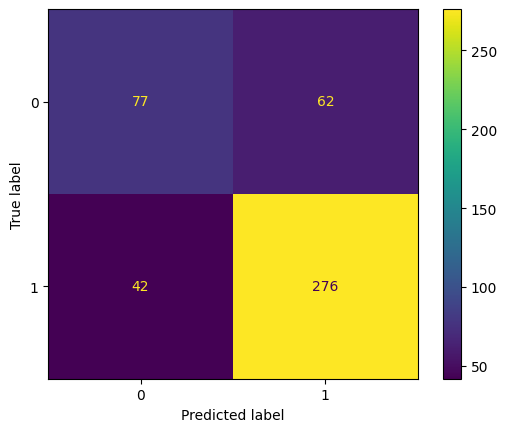

In [23]:
cm = confusion_matrix(test_labels, final_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()